# 1. Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## 2. Load DarkNet

In [2]:
!ls -la "/content/gdrive/MyDrive/darknet"

total 16
drwx------ 2 root root 4096 May 19 05:27 bin
drwx------ 2 root root 4096 May 19 05:29 cfg
drwx------ 2 root root 4096 May 19 05:29 data
drwx------ 2 root root 4096 May 19 05:28 weights


In [3]:
# Colab VM에 darknet 폴더를 만든다.
import os
if not os.path.exists('darknet'):
    os.makedirs('darknet')
%cd darknet
%ls

/content/darknet


In [4]:
# 1.Verify that the compiled Darknet exists in the Google drive.
!ls -la '/content/gdrive/MyDrive/darknet/bin/darknet'

# 2.Copy the Darknet compiled version to the VM
!cp '/content/gdrive/MyDrive/darknet/bin/darknet' ./darknet

# 3.Set execution permissions
!chmod +x ./darknet

-rw------- 1 root root 6211024 May 19 05:28 /content/gdrive/MyDrive/darknet/bin/darknet


# 3. Test Yolo

In [5]:
# 내 구글 드라이브에 있는 필요한 파일을 VM으로 가져온다.
!cp -r '/content/gdrive/MyDrive/darknet/weights' .
!cp -r '/content/gdrive/MyDrive/darknet/cfg' .
!cp -ar '/content/gdrive/MyDrive/darknet/data' .
!cp -r '/content/gdrive/MyDrive/주민혁 폴리텍/주민혁 2학년 1학기/월 자율주행자동차 - 송정현 교수님/Custom_YOLO4/custom' .

# VM의 darknet 폴더에 backup 폴더를 만든다.
if not os.path.exists('./backup'):
    os.makedirs('./backup')

%ls

backup/  cfg/  custom/  darknet*  data/  weights/


In [6]:
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

In [7]:
import zipfile
import os

# 2. 원본 zip 파일 경로 (원하는 zip 파일 경로로 변경)
zip_path = '/content/gdrive/MyDrive/Test/Dataset/t_dataset_aug_f.zip'

# 3. 압축 해제 위치 설정
extract_path = '/content/dataset'

# 4. 압축 해제
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# 5. 압축 해제 후 확인
print("압축 해제 완료. 파일 목록:")
print(os.listdir(extract_path))

압축 해제 완료. 파일 목록:
['dataset']


In [ ]:
!./darknet detect cfg/yolov4.cfg weights/yolov4.weights '/content/dataset/dataset/1008006_610.jpg'
imShow('predictions.jpg')

# 4. Custom Yolo Training and Test

In [8]:
import os
import glob

label_dir = '/content/dataset/dataset/'  # 여기에 라벨 파일들이 있음

id_mapping = {
    11: 0,
    13: 1
}

label_files = glob.glob(os.path.join(label_dir, '*.txt'))

converted = 0
skipped = 0

for file_path in label_files:
    new_lines = []
    with open(file_path, 'r') as f:
        for line in f:
            if line.strip() == "":
                continue
            parts = line.strip().split()
            try:
                original_id = int(float(parts[0]))  # ← 핵심 수정
            except ValueError:
                print(f"❌ 잘못된 라벨: {file_path} → {line.strip()}")
                continue

            if original_id in id_mapping:
                parts[0] = str(id_mapping[original_id])
                new_lines.append(' '.join(parts))
                converted += 1
            else:
                skipped += 1

    # 다시 저장
    with open(file_path, 'w') as f:
        f.write('\n'.join(new_lines) + '\n')

print(f"✅ 변환 완료: {converted}개 라벨 재매핑됨")
print(f"⚠ 무시된 클래스 항목: {skipped}개")


✅ 변환 완료: 2960개 라벨 재매핑됨
⚠ 무시된 클래스 항목: 0개


In [10]:
import os
import glob
import random

# 1. 이미지/라벨이 섞여있는 폴더
dataset_dir = '/content/dataset/dataset/'

# 2. 결과 저장 경로
save_txt_dir = '/content/darknet/custom/'
os.makedirs(save_txt_dir, exist_ok=True)

# 3. 이미지 파일들 불러오기
image_extensions = ['*.jpg', '*.png', '*.jpeg']
image_paths = []
for ext in image_extensions:
    image_paths.extend(glob.glob(os.path.join(dataset_dir, ext)))

# 4. 셔플 후 분할
random.shuffle(image_paths)
split_ratio = 0.8
split_idx = int(len(image_paths) * split_ratio)

train_imgs = image_paths[:split_idx]
test_imgs = image_paths[split_idx:]

✅ 완료: 2056 train / 514 test 이미지 분할됨
📁 저장 위치: /content/darknet/custom//train.txt, test.txt


In [14]:
import shutil
import os

# 6. 실제 복사 대상 폴더 생성
train_dir = '/content/dataset/train'
test_dir = '/content/dataset/test'

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# 7. 이미지 + 같은 이름의 라벨(.txt) 파일 복사 함수
def copy_with_label(file_list, dest_dir):
    new_paths = []
    for img_path in file_list:
        # 이미지 복사
        shutil.copy(img_path, dest_dir)

        # 복사된 이미지 경로 기록
        filename = os.path.basename(img_path)
        new_img_path = os.path.join(dest_dir, filename)
        new_paths.append(new_img_path)

        # 라벨 파일 경로
        label_path = os.path.splitext(img_path)[0] + '.txt'
        if os.path.exists(label_path):
            shutil.copy(label_path, dest_dir)
        else:
            print(f"⚠ 라벨 누락: {label_path}")
    return new_paths

# 8. 실제 복사 및 새 경로 리스트 받기
train_new_paths = copy_with_label(train_imgs, train_dir)
test_new_paths = copy_with_label(test_imgs, test_dir)

print(f"📦 이미지 + 라벨 복사 완료")
print(f"📂 train → {train_dir}")
print(f"📂 test  → {test_dir}")

# 5. 리스트 저장 함수
def save_list(path_list, save_path):
    with open(save_path, 'w') as f:
        for p in path_list:
            f.write(p + '\n')

# 새 경로 리스트로 저장
save_list(train_new_paths, os.path.join(save_txt_dir, 'train.txt'))
save_list(test_new_paths, os.path.join(save_txt_dir, 'test.txt'))

print(f"✅ 완료: {len(train_new_paths)} train / {len(test_new_paths)} test 이미지 분할됨")
print(f"📁 저장 위치: {save_txt_dir}/train.txt, test.txt")


📦 이미지 + 라벨 복사 완료
📂 train → /content/dataset/train
📂 test  → /content/dataset/test
✅ 완료: 2056 train / 514 test 이미지 분할됨
📁 저장 위치: /content/darknet/custom//train.txt, test.txt


In [15]:
def update_cfg_file(cfg_path, num_classes):
    new_lines = []
    with open(cfg_path, 'r') as f:
        lines = f.readlines()

    for i in range(len(lines)):
        line = lines[i].strip()
        if line.startswith('classes='):
            new_lines.append(f'classes={num_classes}\n')
        elif line.startswith('filters='):
            # filters = (num_classes + 5) * 3
            new_lines.append(f'filters={(num_classes + 5) * 3}\n')
        else:
            new_lines.append(lines[i])

    # 덮어쓰기
    with open(cfg_path, 'w') as f:
        f.writelines(new_lines)

# 경로 설정
train_cfg = '/content/darknet/custom/custom-train-yolo4.cfg'
test_cfg = '/content/darknet/custom/custom-test-yolo4.cfg'

# 실행
update_cfg_file(train_cfg, num_classes=2)
update_cfg_file(test_cfg, num_classes=2)

print("✅ cfg 파일 수정 완료 (filters & classes)")

✅ cfg 파일 수정 완료 (filters & classes)


In [13]:
def update_cfg_all(path, num_classes=2, max_batches=4000):
    filters_value = (num_classes + 5) * 3
    step1 = int(max_batches * 0.8)
    step2 = int(max_batches * 0.9)

    new_lines = []
    with open(path, 'r') as f:
        lines = f.readlines()

    for i in range(len(lines)):
        line = lines[i].strip()

        # filters 바로 수정
        if line.startswith('filters='):
            new_lines.append(f'filters={filters_value}\n')
        # classes 수정
        elif line.startswith('classes='):
            new_lines.append(f'classes={num_classes}\n')
        # max_batches 수정
        elif line.startswith('max_batches'):
            new_lines.append(f'max_batches = {max_batches}\n')
        # steps 수정
        elif line.startswith('steps'):
            new_lines.append(f'steps = {step1},{step2}\n')
        else:
            new_lines.append(lines[i])

    with open(path, 'w') as f:
        f.writelines(new_lines)

    print(f"✅ {os.path.basename(path)} 수정 완료:")
    print(f"   - classes = {num_classes}")
    print(f"   - filters = {filters_value}")
    print(f"   - max_batches = {max_batches}")
    print(f"   - steps = {step1},{step2}\n")


# 실제 파일 경로
train_cfg_path = '/content/darknet/custom/custom-train-yolo4.cfg'
test_cfg_path = '/content/darknet/custom/custom-test-yolo4.cfg'

# 둘 다 적용
update_cfg_all(train_cfg_path, num_classes=2, max_batches=4000)
update_cfg_all(test_cfg_path, num_classes=2, max_batches=4000)


✅ custom-train-yolo4.cfg 수정 완료:
   - classes = 2
   - filters = 21
   - max_batches = 4000
   - steps = 3200,3600

✅ custom-test-yolo4.cfg 수정 완료:
   - classes = 2
   - filters = 21
   - max_batches = 4000
   - steps = 3200,3600



In [16]:
# Custom Yolo Training
!./darknet detector train custom/custom_data.data custom/custom-train-yolo4.cfg weights/yolov4.conv.137 -dont_show -map

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 161 Avg (IOU: 0.000000), count: 1, class_loss = 0.000310, iou_loss = 0.000000, total_loss = 0.000310 
 total_bbox = 563235, rewritten_bbox = 0.408000 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 139 Avg (IOU: 0.682048), count: 14, class_loss = 3.172772, iou_loss = 90.841179, total_loss = 94.013954 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 150 Avg (IOU: 0.689569), count: 7, class_loss = 1.338835, iou_loss = 8.785322, total_loss = 10.124157 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 161 Avg (IOU: 0.000000), count: 1, class_loss = 0.002162, iou_loss = 0.000000, total_loss = 0.002162 
 total_bbox = 563256, rewritten_bbox = 0.407985 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 139 Avg (IOU: 0.550953), count: 4, class_loss = 2.135699, iou_loss = 40.388008, total_loss = 42.523708 
v3 (iou los

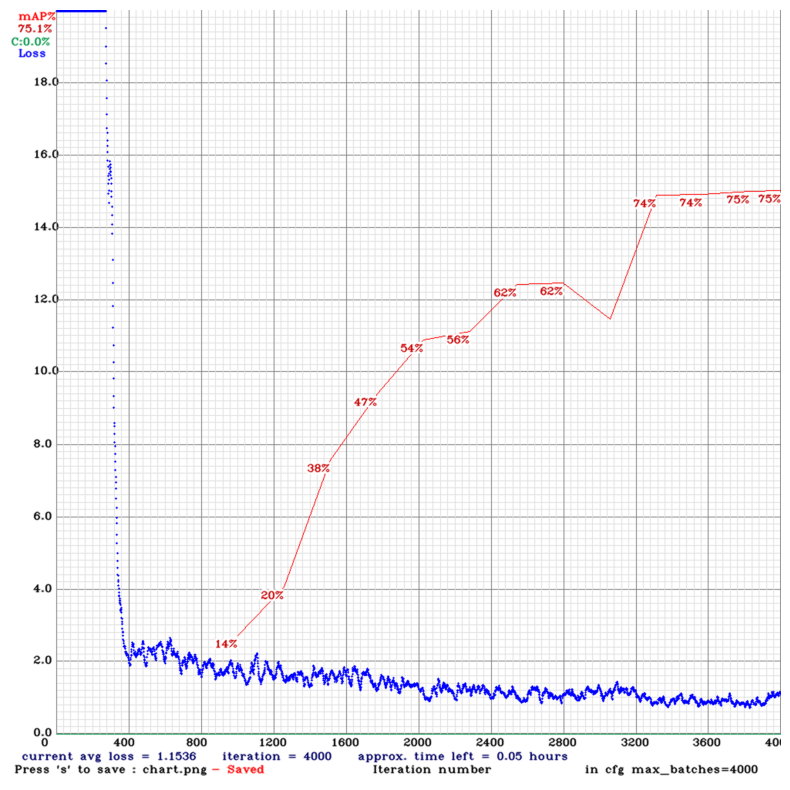

In [17]:
# 학습현황 확인
imShow('chart_custom-train-yolo4.png')

In [20]:
# 학습된 weight 파일 성능 측정(mAP)
!./darknet detector map custom/custom_data.data custom/custom-train-yolo4.cfg /content/gdrive/MyDrive/Test/backup2/custom-train-yolo4_final.weights -points 0

 CUDA-version: 12050 (12040)
, cuDNN: 9.2.1, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 4.5.4
 0 : compute_capability = 750, cudnn_half = 1, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     21       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  21 0.196 BF
   1 conv     21       3 x 3/ 2    416 x 416 x  21 ->  208 x 208 x  21 0.343 BF
   2 conv     21       1 x 1/ 1    208 x 208 x  21 ->  208 x 208 x  21 0.038 BF
   3 route  1 		                           ->  208 x 208 x  21 
   4 conv     21       1 x 1/ 1    208 x 208 x  21 ->  208 x 208 x  21 0.038 BF
   5 conv     21       1 x 1/ 1    208 x 208 x  21 ->  208 x 208 x  21 0.038 BF
   6 conv     21       3 x 3/ 1    208 x 208 x  21 ->  208 x 208 x  21 0.343 BF
   7 Shortcut Layer: 4,  wt = 0, wn = 0, outputs: 208 x 208 x  21 0.001 BF
   8 conv 

In [ ]:
# 성능(mAP)이 가장 좋은 weight만 남겨 두고 구글 드라이브에 복사해 둔다.
if os.path.exists('./backup'):
    !cp -r ./backup "/content/gdrive/MyDrive/Custom_YOLO4/backup"
    !cp chart_custom-train-yolo4.png "/content/gdrive/MyDrive/Custom_YOLO4/backup"

if not os.path.exists('./backup'):
    os.makedirs('./backup')
    !cp -r "/content/gdrive/MyDrive/Custom_YOLO4/backup/custom-train-yolo4_final.weights" ./backup

cp: cannot create directory '/content/gdrive/MyDrive/Custom_YOLO4/backup': No such file or directory
cp: cannot create regular file '/content/gdrive/MyDrive/Custom_YOLO4/backup': No such file or directory


In [ ]:
!ls -al ./backup

total 8
drwxr-xr-x 2 root root 4096 Jun  2 07:22 .
drwxr-xr-x 7 root root 4096 Jun  2 07:28 ..


 CUDA-version: 12050 (12040)
, cuDNN: 9.2.1, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 4.5.4
 0 : compute_capability = 750, cudnn_half = 1, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     21       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  21 0.196 BF
   1 conv     21       3 x 3/ 2    416 x 416 x  21 ->  208 x 208 x  21 0.343 BF
   2 conv     21       1 x 1/ 1    208 x 208 x  21 ->  208 x 208 x  21 0.038 BF
   3 route  1 		                           ->  208 x 208 x  21 
   4 conv     21       1 x 1/ 1    208 x 208 x  21 ->  208 x 208 x  21 0.038 BF
   5 conv     21       1 x 1/ 1    208 x 208 x  21 ->  208 x 208 x  21 0.038 BF
   6 conv     21       3 x 3/ 1    208 x 208 x  21 ->  208 x 208 x  21 0.343 BF
   7 Shortcut Layer: 4,  wt = 0, wn = 0, outputs: 208 x 208 x  21 0.001 BF
   8 conv  

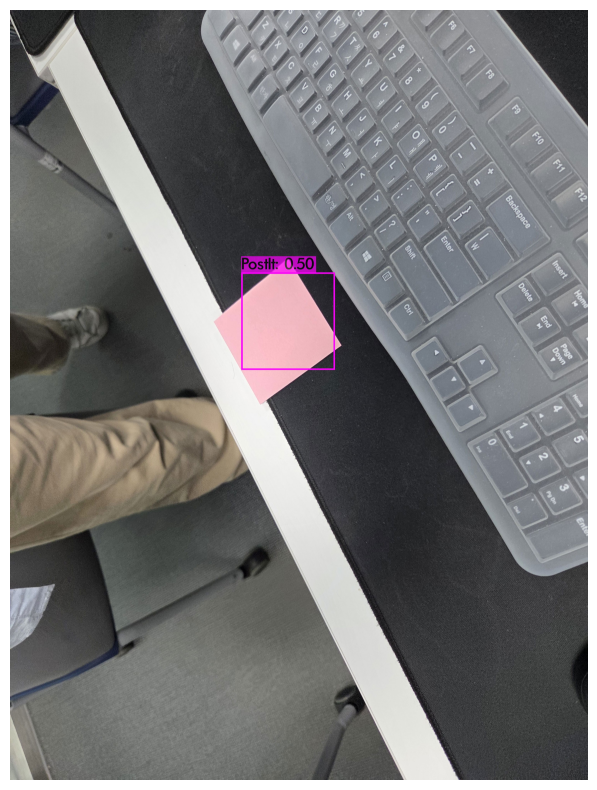

In [46]:
# Custom Yolo4 Test
# weight 경로를 정확하게 전체 경로로 수정하여 실행
!./darknet detector test custom/custom_data.data custom/custom-test-yolo4.cfg /content/gdrive/MyDrive/Test/backup2/custom-train-yolo4_final.weights '/content/gdrive/MyDrive/Test/backup/20250602_111405.jpg' -dont-show -thresh 0.5 #0.5가 잘나오는 편

imShow('predictions.jpg')